In [1]:
import pathlib 
import numpy as np
import os
import pandas as pd
import math
from scipy.spatial.transform import Rotation
# import imageio
import os
import glob
from matplotlib import pyplot as plt
import pickle as pkl
from sklearn.decomposition import PCA 
import re
import matplotlib.animation as anm

In [2]:
def update(num, ax_list, motions, motions_pca):
    for i, (m, p) in enumerate(zip(motions[:,:,:,num], motions_pca[:,:,:,num])):
        title = ax_list[i].get_title()
        ax_list[i].clear()
        ax_list[i+len(ax_list)//2].clear()
        ax_list[i].set_title(title)
        ax_list[i+len(ax_list)//2].set_title(title)
        ax_list[i].plot(m[:, 0], -m[:, 1], ".", c="b")
        ax_list[i+len(ax_list)//2].plot(p[:, 0], -p[:, 1], ".", c="b")
        ax_list[i].set_ylim([-100, 75])
        ax_list[i].set_xlim([-100, 100])
        ax_list[i+len(ax_list)//2].set_ylim([-100, 75])
        ax_list[i+len(ax_list)//2].set_xlim([-100, 100])


    return ax_list, motions

def clip(arr):
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    arr = (arr * 255).astype(np.uint8)
    return arr

In [3]:
source_dir = pathlib.Path("/home/nakazawa/FaceAnalysis/RAVDESS/")
target_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/full_av/")

In [4]:
files = list(target_dir.glob("train/*.npy"))

In [14]:
faces.shape

(204, 99)

In [15]:
faces = None
for f in files:
    npy = np.load(f).T
    npy = npy * 0.01
    if faces is not None:
        faces = np.concatenate([faces, npy])
    else:
        faces = npy

In [16]:
pca = PCA(n_components=27)
pca.fit(faces)

PCA(n_components=27)

In [19]:
np.linalg.norm(pca.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<BarContainer object of 27 artists>

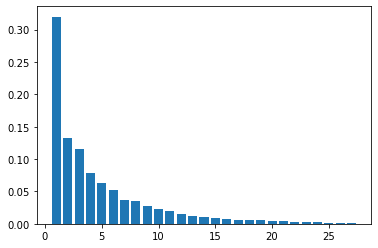

In [12]:
plt.bar(np.arange(pca.n_components)+1, pca.explained_variance_ratio_)

In [111]:
W = pca.components_

In [112]:
W.shape

(3, 204)

In [113]:
np.random.randint(0, faces.shape[1])

77241

In [114]:
f_t = pca.transform(faces.T)


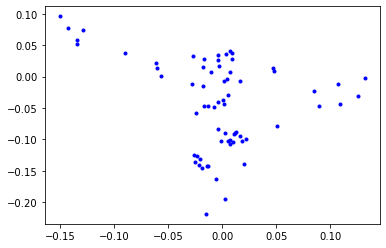

In [115]:
n = 2
%matplotlib inline
plt.plot(pca.components_[n, ::3], -pca.components_[n, 2::3], ".", c="b")
plt.show()

In [4]:
motion_paths = list(target_dir.glob("train/01-01-*-01-01-01-01.npy"))

In [5]:
motion_paths

[PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-01-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-02-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-03-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-04-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-05-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-06-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-07-01-01-01-01.npy'),
 PosixPath('/home/takeuchi/data/RAVDESS_processed/full_av/train/01-01-08-01-01-01-01.npy')]

In [117]:
exp = np.load(motion_paths[0])
motions = np.zeros([len(motion_paths), *exp.shape], dtype=exp.dtype)
motions_pca = np.zeros([len(motion_paths), *exp.shape], dtype=exp.dtype)
transformed = []
for i in range(len(motion_paths)):
    motions[i] = np.load(motion_paths[i])[:, :exp.shape[1]] * 0.01
    motions_pca[i] = pca.inverse_transform(pca.transform(motions[i].T)).T
    transformed.append(pca.transform(motions[i].T))

In [118]:
np.dot(W, motions[0]).shape

(3, 99)

In [119]:
motion_length = 99
ax_num = len(motions)
motion = motions.reshape(ax_num, -1, 3, motion_length)
motion_pca = motions_pca.reshape(ax_num, -1, 3, motion_length)

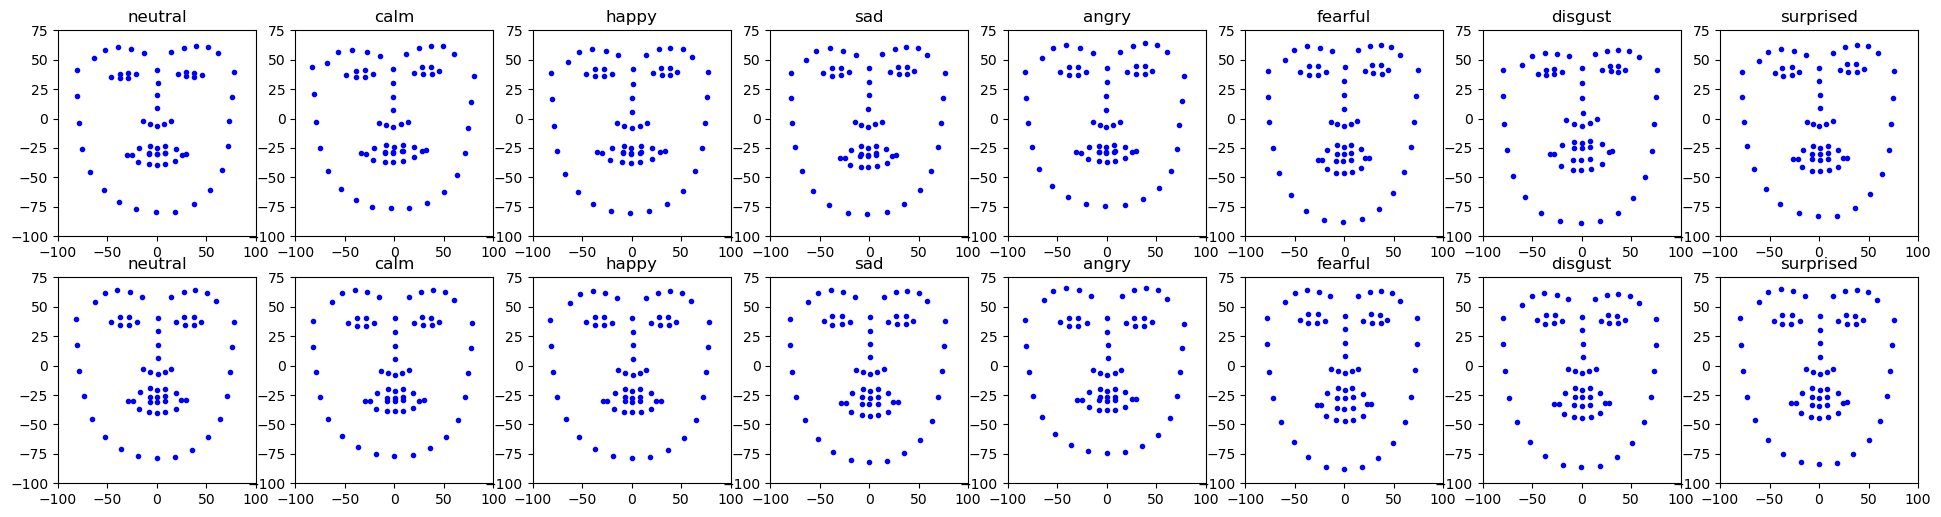

In [120]:

captions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
fig = plt.figure(figsize=[3*ax_num, 6], dpi=100)
ax_list = [fig.add_subplot(2, ax_num, i+1) for i in range(ax_num*2)]
plots = []
for i, cap in enumerate(captions):
    ax_list[i].set_title(cap)
    ax_list[i+ax_num].set_title(cap)
#     ax_list[i].set_ylim([-100, 75])
#     ax_list[i].set_xlim([-100, 100])
anim = anm.FuncAnimation(fig, update, fargs=(ax_list, motion*100, motion_pca*100), frames=motion_length, interval=100)
# fig.show()

In [23]:
anim.save("Sample.gif", writer = 'imagemagick')

In [4]:
rotation_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/Homography2//")

In [16]:
emotion_train_files = [f for f in target_dir.glob("train/*.npy") if re.match(r"01-01-..-01-..-..-...npy", f.name)]
emotion_test_files = [f for f in target_dir.glob("test/*.npy") if re.match(r"01-01-..-01-..-..-...npy", f.name)]

In [17]:
emotion_train_files.sort()

In [18]:
emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]


In [101]:
motion_list = [[] for e in emotion_list]
for f in emotion_train_files:
    motion = np.load(f) * 0.01
    traj = pca.transform(motion.T).T
    rot = np.load(rotation_dir / f.name)
    rot[:, 3:] =- rot[:, 3:].mean(axis=0)
    rot[:, 3:] = rot[:, 3:] * 0.01
#     rot = rot.reshape(-1, 12)

    motion = np.concatenate([rot.T, motion])
    motion = np.concatenate([traj, motion])
    for i in range(len(emotion_list)):
        if f.name.startswith(f"01-01-0{i+1}"):
            motion_list[i].append(motion)
            

In [29]:
297 / 3

99.0

In [14]:
emotion_data_dir =  pathlib.Path("/home/takeuchi/data/RAVDESS_processed/EmotionData//")

In [15]:
emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
rotation_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/Homography2//")

In [72]:
# for motions, emotion in zip(motion_list, emotion_list):
#     fname = emotion + ".npy"
#     np.save(rotation_dir / "train" / fname, np.concatenate(motions, axis=1))
for motions, emotion in zip(motion_list, emotion_list):
    for i, m in enumerate(motions):
        np.save(rotation_dir / "train" / f"{emotion}_{i}", m)

In [99]:
for f in emotion_test_files:
    motion = np.load(f)
    motion = motion * 0.01
    traj = pca.transform(motion.T).T
    rot = np.load(rotation_dir / f.name)
#     rot = rot.reshape(-1, 12)
    rot[:, 3:] =- rot[:, 3:].mean(axis=0)
    rot[:, 3:] = rot[:, 3:] * 0.01
    motion = np.concatenate([rot.T, motion])
    motion = np.concatenate([traj, motion])

    np.save(rotation_dir / "test"/ f.name , motion)

In [66]:
paths = rotation_dir.glob(f"test/*.npy")
for p in paths:
    if p.stem.split("_")[0] in emotion_list:
        p.rename(rotation_dir / "test" / p.name.split("_")[-1])

In [35]:
for i , emo in enumerate(emotion_list):
    paths = rotation_dir.glob(f"test/01-01-0{i+1}-*.npy")
    for p in paths:
#         print(f"test/{emo}_{p.name}")
        p.rename(rotation_dir / f"test/{emo}_{p.name}")

# pcaのデータせっと作る

In [8]:
target_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/full_av/")
files = list(target_dir.glob("train/*.npy"))
faces = []
for f in files:
    npy = np.load(f)
    npy = npy * 0.01
    faces.append(npy)
faces = np.concatenate(faces, axis=1)

In [9]:
pca = PCA(n_components=27)
pca.fit(faces.T)

PCA(n_components=27)

In [10]:
pca.explained_variance_ratio_.sum()

0.994028773220534

In [29]:
transformed = []
motion_list = [[] for e in emotion_list]
content_list = [[] for e in emotion_list]

for f in emotion_train_files:
    motion = np.load(f) * 0.01
    rot = np.load(rotation_dir / f.name)
    rot[:, 3:] =- rot[:, 3:].mean(axis=0)
    rot[:, 3:] = rot[:, 3:] * 0.01
    coded = pca.transform(motion.T).T
    coded = np.concatenate([rot.T, coded])
    transformed.append(pca.transform(motion.T))
    for i in range(len(emotion_list)):
        if f.name.startswith(f"01-01-0{i+1}"):
            motion_list[i].append(coded)
            content_list[i].append(int(f.stem[-7:-6]))

In [20]:
transformed = np.concatenate(transformed)
transformed = transformed.reshape(-1, 27)
m, std = transformed.mean(axis=0), transformed.std(axis=0)

In [21]:
pca_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/content_split/PCAdata_normalize/")
rotation_dir = pathlib.Path("/home/takeuchi/data/RAVDESS_processed/Homography2//")

In [30]:
for motions, emotion, content in zip(motion_list, emotion_list, content_list):
    for i, m in enumerate(motions):
        m[6:] = m[6:] / std[:, None]
        if content[i] == 1:
            np.save(pca_dir / "train_1" / f"{emotion}_{i}", m) # 分散を揃える

In [31]:
for f in emotion_test_files:
    motion = np.load(f)
    motion = motion * 0.01
    rot = np.load(rotation_dir / f.name)
    rot[:, 3:] =- rot[:, 3:].mean(axis=0)
    rot[:, 3:] = rot[:, 3:] * 0.01
    coded = pca.transform(motion.T).T /  std[:, None]
    coded = np.concatenate([rot.T, coded])
    content = f.stem[-7:-6]
    np.save(pca_dir / f"test_{content}"/ f.name , coded)

In [32]:
np.save(pca_dir / "mean.npy", pca.mean_)

In [33]:
np.save(pca_dir / "components.npy", pca.components_ * std[:, None])

In [140]:
coded.shape

(27, 96)

In [170]:
pca.components_.shape

(27, 204)

In [164]:
f = np.dot(coded.T, pca.components_) + pca.mean_

In [169]:
pca.mean_.shape

(204,)

In [167]:
f = f.reshape(-1, 68, 3)

In [158]:
motion.shape

(204, 96)

In [122]:
!cat ./FeatureExtraction

cat: ./FeatureExtraction: そのようなファイルやディレクトリはありません
